In [2]:
import os
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd

In [3]:
file = open("hw4_tr7.pkl",'rb')
train_data = pickle.load(file)
file.close()

In [4]:
file = open("hw4_te7.pkl",'rb')
test_data = pickle.load(file)
file.close()

In [5]:
train_data.shape


(6265, 28, 28)

In [6]:
BATCH = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH)

In [138]:
# Ref : https://github.com/pytorch/examples/blob/master/vae/main.py
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.encode_conv1 = nn.Sequential(
                nn.Conv2d(1, 8, kernel_size=2, stride=1),
                nn.ReLU(),       
                nn.MaxPool2d(kernel_size=2, stride=1))


        self.encode_conv2 = nn.Sequential(
                nn.Conv2d(8,16, kernel_size=2, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1))
        
        
        self.encode_conv3 = nn.Sequential(
                nn.Conv2d(16,32, kernel_size=2, stride=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.encode_conv4 = nn.Sequential(
                nn.Conv2d(32,64, kernel_size=2, stride=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(64, 5)
        self.fc2 = nn.Linear(64, 5)
        self.decode_start = nn.Linear(5, 64)
        
        self.decode_conv4 = nn.Sequential(
                nn.ConvTranspose2d(64,32, kernel_size=2, stride=2),
                nn.ReLU(),
                nn.MaxUnpool2d(kernel_size=2, stride=2))
        
        self.decode_conv3 = nn.Sequential(
                nn.Conv2d(32,16, kernel_size=2, stride=2),
                nn.ReLU(),
                nn.MaxUnpool2d(kernel_size=2, stride=2))
        
        self.decode_conv2 = nn.Sequential(
                nn.Conv2d(16,8, kernel_size=2, stride=1),
                nn.ReLU(),
                nn.MaxUnpool2d(kernel_size=2, stride=1))
        
        self.decode_conv1 = nn.Sequential(
                nn.Conv2d(8, 1, kernel_size=2, stride=1),
                nn.ReLU(),       
                nn.MaxUnpool2d(kernel_size=2, stride=1))
        
#         self.fc1 = nn.Linear(in_features=int(16256), out_features=513)
    
    def encode(self, x):
        out = x[:,np.newaxis,:,:]
        out = self.encode_conv1(out)
        out = self.encode_conv2(out)
        out = self.encode_conv3(out)
        out = self.encode_conv4(out)
        out  = out.view(200,-1)
        return self.fc1(out), self.fc2(out)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        print('decod shape')
        print(z.shape)
        out = self.decode_start(z)
        print('shape')
        print(z.shape)
#         out = z[:,np.newaxis,:,:]
        out = self.decode_conv4(z)
        out = self.decode_conv3(out)
        out = self.decode_conv2(out)
        out = self.decode_conv1(out)
#         print(out.shape)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [139]:
model = NeuralNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [140]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [141]:
def train(epoch):
    model.train()
    train_loss = 0
    for i, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print(loss.item())
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [142]:
for epoch in range(1000):
    train(epoch)

decod shape
torch.Size([200, 5])


AttributeError: 'NeuralNet' object has no attribute 'decode_starts'

In [83]:
state_dict = model.state_dict()

In [84]:
state_dict['fc22.weight'].shape

torch.Size([5, 400])

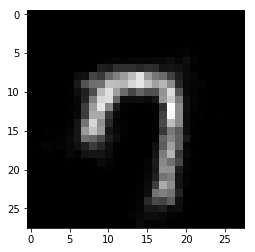

In [85]:
z = torch.tensor([0.5,0.5,0.5,0.5,0.5]).cuda()
ans = model.decode(z)
ans = ans.reshape((28,28))
plt.imshow(ans.cpu().detach().numpy(), cmap="gray")

In [55]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
    for epoch in range(1, 10):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')